In [1]:
from HelpFunctions.date_and_time import most_recent_thursday, split_time
from DAX.HelpFunctions.get_dax_data import get_dax_data
from datetime import timedelta
from HelpFunctions.calc_score import evaluate_horizon
import pandas as pd
from DAX.Models.baseline import baseline
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

# import importlib
# importlib.reload(Energy.Models)

/Users/elias/Desktop/PTSFC/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
df = get_dax_data()

In [3]:
# We have to start with the tuesday data
start_date_excl = most_recent_thursday(df) - timedelta(days=1)
df_cval = df.loc[df.index < start_date_excl]
df_cval.index = df_cval.index.date

In [4]:
df_cval.tail()

,Close,ret1,ret2,ret3,ret4,ret5
2023-11-08,15229.599609,0.506613,0.616686,0.265294,0.566290,2.031917
2023-11-09,15352.540039,0.804006,1.310618,1.420692,1.069299,1.370296
2023-11-10,15234.389648,-0.772559,0.031447,0.538060,0.648134,0.296741
2023-11-13,15345.000000,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14,15614.429688,1.740578,2.464012,1.691453,2.495459,3.002072


In [5]:
def evaluate_models(models, df, last_x, years =False, months=False, weeks=False):
    # Check that exactly one of the boolean parameters is True
    if sum([years, months, weeks]) != 1:
        raise ValueError("Exactly one of the boolean parameters (years, months, weeks) must be True.")
    
    years = int(years)
    months = int(months)
    weeks = int(weeks)
        
    for m in models:
        print(f'*********** Start the evaluation of Model {m["name"]} ***********')
        m['evaluation'] = evaluate_model(m, df, last_x, years, months, weeks)
        
def evaluate_model(model, df, last_x, years, months, weeks):
    df_before = df
    evaluation = pd.DataFrame()
    
    for w in range(last_x):
        print(f'Iteration {w+1} of {last_x}')
        df_before, df_after = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)
        pred = model['function'](df_before)
        # Makes sure we try to find observations for dates that have an observation (e.g. 05-01 is missing)
        dates = [[horizon+1, d] for horizon,d in enumerate(pred['forecast_date']) if d in df.index]
        pred = pred.set_index('forecast_date')

        
        # Add observations to pred
        pred['observation'] = ''
        pred['score'] = ''
        for h,d in dates:
            # Look up the right observation for date d
            o = df.loc[d][f'ret{h}']
            pred.loc[d,'observation'] = o
    
        # Add scores to pred
        for index, row in pred.iterrows():
            quantile_preds = row[['q0.025','q0.25','q0.5','q0.75','q0.975']]
            observation = row['observation']
            
            
            
            print(f'Obs: :{observation}:')
            print(type(observation))
            score = evaluate_horizon(quantile_preds, observation)
            
            pred.at[index, 'score'] = score
            
        evaluation = pd.concat([evaluation, pred])
    evaluation = evaluation.sort_index()
    
    return evaluation

In [6]:
from DAX.Models.garch11_t import garch11_t
from DAX.Models.garch11 import garch11
from DAX.Models.baseline_100 import baseline_100
from DAX.Models.baseline_300 import baseline_300

models = [
    # {
    #     'name': 'baseline',
    #     'function': baseline
    #  },
    {
        'name': 'garch11',
        'function': garch11
     },
    {
        'name': 'garch11_t',
        'function': garch11_t
     },
    # {
    #     'name': 'baseline_300',
    #     'function': baseline_300
    #  },
    # {
    #     'name': 'baseline_100',
    #     'function': baseline_100
    #  },
]


In [7]:
evaluate_models(models, df, 100, weeks=True)

*********** Start the evaluation of Model garch11 ***********
Iteration 1 of 100
Iteration:      1,   Func. Count:      5,   Neg. LLF: 58562.12834412739
Iteration:      2,   Func. Count:     14,   Neg. LLF: 17291.697399850902
Iteration:      3,   Func. Count:     22,   Neg. LLF: 25630.1322021882
Iteration:      4,   Func. Count:     28,   Neg. LLF: 14490.446789205867
Iteration:      5,   Func. Count:     32,   Neg. LLF: 14490.446785763688
Iteration:      6,   Func. Count:     35,   Neg. LLF: 14490.44678576303
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14490.446785763688
            Iterations: 6
            Function evaluations: 35
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      5,   Neg. LLF: 61635.988017194366
Iteration:      2,   Func. Count:     14,   Neg. LLF: 21582.384606913183
Iteration:      3,   Func. Count:     20,   Neg. LLF: 19433.828139835037
Iteration:      4,   Func. Count:     26,   Neg. LLF: 4911

In [8]:
df.tail(10)

,Close,ret1,ret2,ret3,ret4,ret5
Date,,,,,,
2023-11-07 00:00:00+01:00,15152.639648,0.110074,-0.241319,0.059678,1.525304,2.284918
2023-11-08 00:00:00+01:00,15229.599609,0.506613,0.616686,0.265294,0.566290,2.031917
2023-11-09 00:00:00+01:00,15352.540039,0.804006,1.310618,1.420692,1.069299,1.370296
2023-11-10 00:00:00+01:00,15234.389648,-0.772559,0.031447,0.538060,0.648134,0.296741
2023-11-13 00:00:00+01:00,15345.000000,0.723434,-0.049125,0.754881,1.261494,1.371568
2023-11-14 00:00:00+01:00,15614.429688,1.740578,2.464012,1.691453,2.495459,3.002072
2023-11-15 00:00:00+01:00,15748.169922,0.852870,2.593448,3.316881,2.544323,3.348329
2023-11-16 00:00:00+01:00,15786.610352,0.243797,1.096667,2.837245,3.560679,2.788120
2023-11-17 00:00:00+01:00,15919.160156,0.836129,1.079926,1.932796,3.673374,4.396808


In [9]:
with open('./Model evaluations/baseline_GARCH11_GARCH21.pkl', 'wb') as f:
    pickle.dump(models, f)
#         
# with open('./Model evaluations/baseline.pkl', 'rb') as f:
#     models = pickle.load(f)

In [10]:
models[0]['evaluation']

,q0.025,q0.25,q0.5,q0.75,q0.975,horizon,observation,score
forecast_date,,,,,,,,
2021-12-17,-2.419128,-0.832504,0.0,0.832504,2.419128,1 day,-0.671907,1.746324
2021-12-20,-3.016514,-1.038084,0.0,1.038084,3.016514,2 day,-2.569966,6.973466
2021-12-21,-2.994791,-1.030609,0.0,1.030609,2.994791,5 day,-1.215823,2.91634
2021-12-22,-3.821828,-1.315220,0.0,1.315220,3.821828,6 day,-0.274934,1.972336
2021-12-23,-4.501410,-1.549087,0.0,1.549087,4.501410,7 day,0.763934,2.763162
...,...,...,...,...,...,...,...,...
2023-11-14,-1.720066,-0.591933,0.0,0.591933,1.720066,1 day,1.740578,4.842831
2023-11-15,-2.271949,-0.781854,0.0,0.781854,2.271949,2 day,2.593448,7.868681
2023-11-16,-3.009908,-1.035811,0.0,1.035811,3.009908,5 day,2.837245,7.776914


In [11]:
horizons = [str(i) + " day" for i in (1, 2, 5, 6, 7)]
scores = []
names = []
for m in models:
    scores_m = m['evaluation'].loc[:,('horizon','score')]
    names.append(f'horizon_{m["name"]}')
    names.append(m["name"])
    scores.append(scores_m)

score_df = pd.concat(scores, axis=1)
score_df.columns = names

In [12]:
score_df

,horizon_garch11,garch11,horizon_garch11_t,garch11_t
forecast_date,,,,
2021-12-17,1 day,1.746324,1 day,1.614074
2021-12-20,2 day,6.973466,2 day,8.085242
2021-12-21,5 day,2.91634,5 day,3.169303
2021-12-22,6 day,1.972336,6 day,1.169337
2021-12-23,7 day,2.763162,7 day,1.813297
...,...,...,...,...
2023-11-14,1 day,4.842831,1 day,4.746533
2023-11-15,2 day,7.868681,2 day,8.194292
2023-11-16,5 day,7.776914,5 day,9.457718


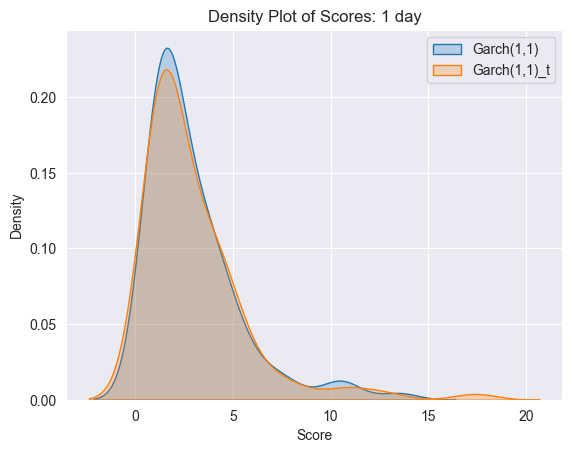

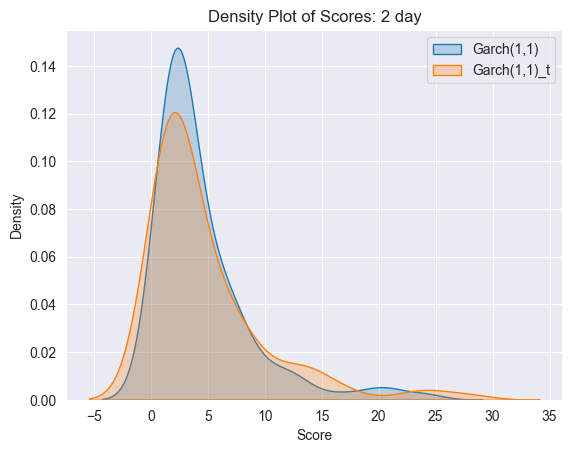

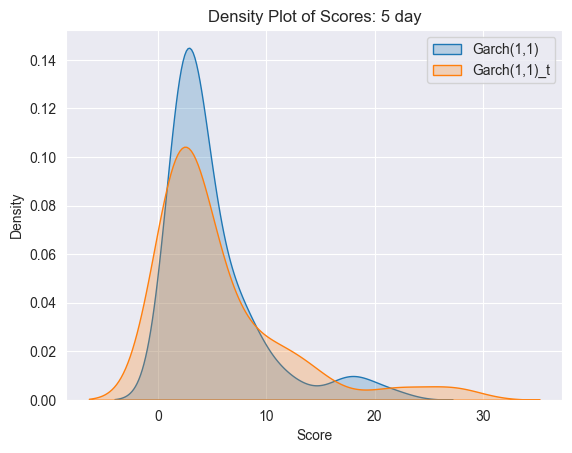

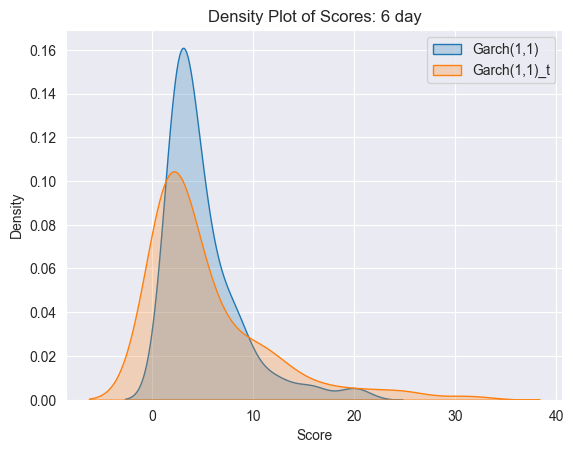

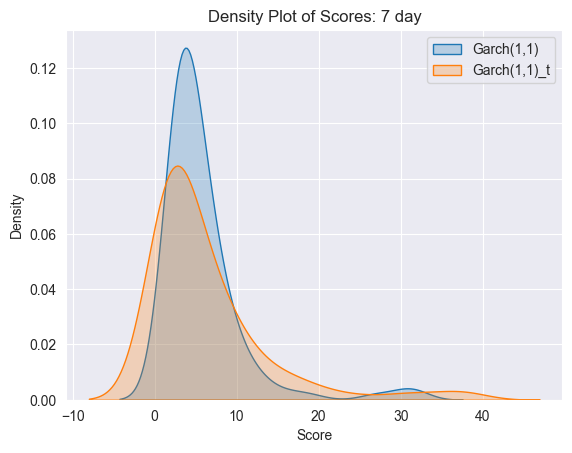

In [13]:
for horizon in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    filtered_df = score_df[score_df['horizon_garch11'] == horizon]
    # sns.kdeplot(data=filtered_df['baseline'], fill=True, label='Baseline')
    sns.kdeplot(data=filtered_df['garch11'], fill=True, label='Garch(1,1)')
    sns.kdeplot(data=filtered_df['garch11_t'], fill=True, label='Garch(1,1)_t')
    # sns.kdeplot(data=filtered_df['baseline_300'], fill=True, label='Baseline 300')
    
    
    # Adding labels and title
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title(f'Density Plot of Scores: {horizon}')
    plt.legend()
    
    # plt.xlim(0,8)
    # Display the plot
    plt.show()

/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_38518/1267894941.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[score_df['garch11'].notna()]


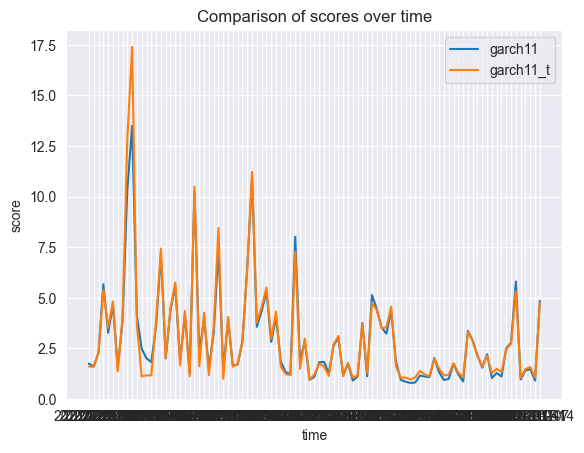

/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_38518/1267894941.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[score_df['garch11'].notna()]


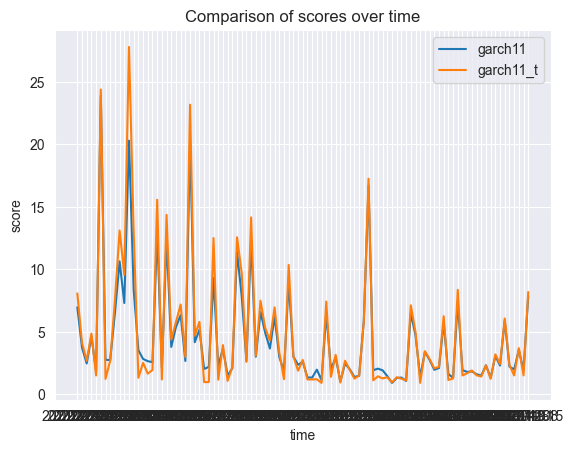

/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_38518/1267894941.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[score_df['garch11'].notna()]


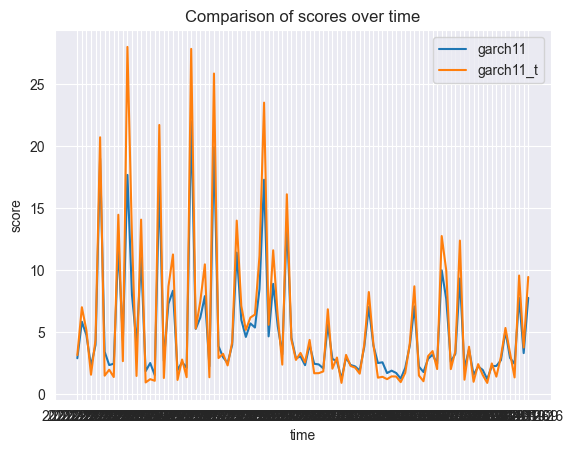

/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_38518/1267894941.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[score_df['garch11'].notna()]


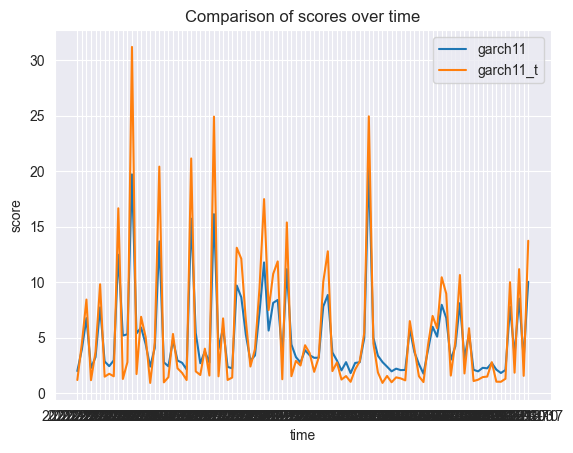

/var/folders/c7/nx3f8qlj38ld0jj0l_0nyp2h0000gn/T/ipykernel_38518/1267894941.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[score_df['garch11'].notna()]


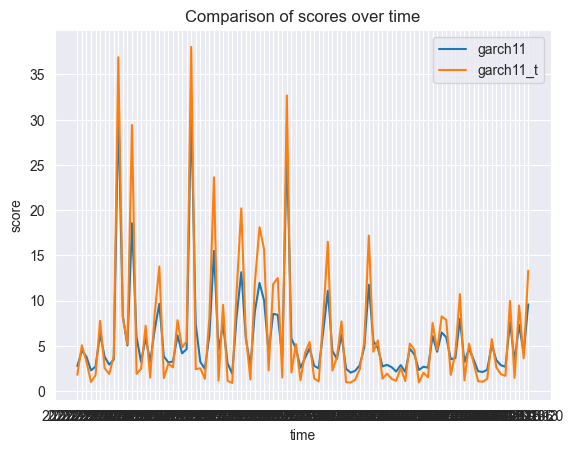

In [16]:
for horizon in [str(i) + " day" for i in (1, 2, 5, 6, 7)]:
    filtered_df = score_df[score_df['horizon_garch11'] == horizon]

    # Plot values from two columns over time
    filtered_df = filtered_df[score_df['garch11'].notna()]
    # plt.plot(score_df_36_no_na.index, score_df_36_no_na['baseline: 36 hour'], label='baseline')
    # plt.plot(filtered_df.index, filtered_df['baseline'], label='baseline')
    # plt.plot(score_df_36_no_na.index, score_df_36_no_na['model2: 36 hour'], label='model2')
    plt.plot(filtered_df.index, filtered_df['garch11'], label='garch11')
    plt.plot(filtered_df.index, filtered_df['garch11_t'], label='garch11_t')
    
    
    # Adding labels and title
    plt.xlabel('time')
    plt.ylabel('score')
    plt.title('Comparison of scores over time')
    
    # Display legend
    plt.legend()
    
    # Show the plot
    plt.show()